# Demo: Fine-Tuning Geneformer on Cell Type Classification

python3.10 pytorch2.4 geneformerV1

In [1]:
pip install -r requirements.txt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 22.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 12.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 13.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 19.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 21.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import mygene
import h5py
import pandas as pd
import anndata as ad
from scipy import sparse
import numpy as np
from datasets import load_from_disk
# imports
import os
import re
import pandas as pd
import numpy as np
import anndata as ad
import collections  
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
import pickle
import gc
import subprocess
import torch
import seaborn as sns; sns.set()
from datasets import load_from_disk

from sklearn.metrics import accuracy_score, f1_score
from transformers import BertForSequenceClassification
from transformers import BertModel, BertTokenizer  
from transformers import BertForSequenceClassification,BertTokenizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import Trainer
from tqdm import tqdm
import os
from transformers import AdamW
from transformers.training_args import TrainingArguments
import torch.optim as optim
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import warnings
warnings.filterwarnings("ignore")
#from collator_for_classification import DataCollatorForCellClassification
#from collator_for_classification import *

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing and Tokenization

We utilized the AEL_GSE142213 dataset from the TISCH2 database, which consists of 3,994 single cells derived from two human patients diagnosed with acute erythroid leukemia (AEL). The data was generated using the 10x Genomics platform and remains untreated. This primary dataset (PMID: 32330454) provides a high-resolution view of the tumor microenvironment in AEL, and was used in our downstream analysis for cell-type classification and embedding extraction using Geneformer.

Data source： http://tisch.comp-genomics.org/gallery/?cancer=AEL&species= (PMID: 32330454)

In [3]:
mg = mygene.MyGeneInfo()

In [5]:
with h5py.File("AEL_GSE142213_expression.h5", "r") as f:
    matrix = f["matrix"]
    data = matrix["data"][:]
    indices = matrix["indices"][:]
    indptr = matrix["indptr"][:]
    shape = matrix["shape"][:]
    

    genes = matrix["features"]["name"][:].astype(str)
    

    cells = matrix["barcodes"][:].astype(str)
expr_matrix = sparse.csc_matrix((data, indices, indptr), shape=shape).T  
meta = pd.read_csv("AEL_GSE142213_CellMetainfo_table.tsv", sep="\t")

In [6]:
meta['n_counts']  = (expr_matrix.toarray()>1).sum(axis=1)

In [7]:
# Query MyGene for Ensembl IDs
gene_info = mg.querymany(genes, scopes='symbol', species='human', fields='ensembl.gene', returnall=True)

# Create a mapping of original symbols to Ensembl IDs
symbol_to_ensembl = {}
for hit in gene_info['out']:
    if 'ensembl' in hit and isinstance(hit['ensembl'], dict) and 'gene' in hit['ensembl']:
        symbol_to_ensembl[hit['query']] = hit['ensembl']['gene']
    elif 'ensembl' in hit and isinstance(hit['ensembl'], list):
        symbol_to_ensembl[hit['query']] = hit['ensembl'][0]['gene']

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
174 input query terms found dup hits:	[('LINC00115', 2), ('SLC35E2A', 2), ('CAMTA1-DT', 2), ('CROCCP2', 2), ('LINC01355', 3), ('NFYC-AS1',
1516 input query terms found no hit:	['AL627309.1', 'AP006222.1', 'AL732372.2', 'AL669831.1', 'AL669831.5', 'AL391244.1', 'AL391244.3', '


In [8]:
genes

array(['AL627309.1', 'AP006222.1', 'AL732372.2', ..., 'MT-ND5', 'MT-ND6',
       'MT-CYB'], dtype='<U100')

In [9]:
gene_list = [symbol_to_ensembl.get(col, col) for col in genes]

In [12]:
# Convert DataFrames to AnnData format
adata = ad.AnnData(X=expr_matrix)
adata.obs = meta
adata.var = pd.DataFrame({'ensembl_id':gene_list},index=gene_list)


# Save to .h5ad format
save_path = './output/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
adata.write_h5ad('output/output.h5ad')  # Replace with your desired output path
print("Conversion complete. Data saved to .h5ad.")

Conversion complete. Data saved to .h5ad.


In [14]:
from geneformer import TranscriptomeTokenizer
tk = TranscriptomeTokenizer({'Cell': 'Cell',
 'UMAP_1': 'UMAP_1',
 'UMAP_2': 'UMAP_2',
 'Celltype (malignancy)': 'Celltype (malignancy)',
 'Celltype (major-lineage)': 'Celltype (major-lineage)',
 'Celltype (minor-lineage)': 'Celltype (minor-lineage)',
 'Cluster': 'Cluster',
 'Sample': 'Sample',
 'Patient': 'Patient',
 'Source': 'Source',
 'Gender': 'Gender',
 'Stage': 'Stage'},nproc=4)
save_path = './token_data/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tk.tokenize_data("output/", output_directory="token_data/", output_prefix="AEL",file_format='h5ad')

Tokenizing mnt/output/output.h5ad
mnt/output/output.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


Saving the dataset (1/1 shards): 100%|██████████| 3994/3994 [00:00<00:00, 14726.16 examples/s]


## Fine tuning

In [17]:
data = load_from_disk("token_data/AEL.dataset/")
data = pd.DataFrame(data)

In [34]:
data

,input_ids,Cell,UMAP_1,UMAP_2,Celltype (malignancy),Celltype (major-lineage),Celltype (minor-lineage),Cluster,Sample,Patient,Source,Gender,Stage,length
0,"[20961, 6417, 8929, 331, 62, 5762, 12292, 6261...",OX1164@AAACCTGAGACACTAA-1,2.778555,-4.570139,Malignant cells,Malignant,Malignant,4,OX1164,OX1164,Tumor,Female,Primary,2048
1,"[331, 8929, 5762, 8799, 20961, 5172, 8646, 510...",OX1164@AAACCTGAGTCGTTTG-1,-3.547933,-6.904181,Malignant cells,Malignant,Malignant,1,OX1164,OX1164,Tumor,Female,Primary,1452
2,"[331, 8929, 4991, 5762, 12794, 9769, 62, 7330,...",OX1164@AAACCTGCAATTGCTG-1,1.246802,-7.357423,Malignant cells,Malignant,Malignant,3,OX1164,OX1164,Tumor,Female,Primary,2048
3,"[8929, 20961, 62, 14395, 5762, 442, 3988, 1732...",OX1164@AAACCTGTCATCGGAT-1,-2.858419,-6.989849,Malignant cells,Malignant,Malignant,6,OX1164,OX1164,Tumor,Female,Primary,1241
4,"[8929, 331, 21200, 9762, 5762, 992, 868, 11916...",OX1164@AAACCTGTCCAAAGTC-1,0.547343,-7.713346,Malignant cells,Malignant,Malignant,3,OX1164,OX1164,Tumor,Female,Primary,1756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3989,"[8167, 13375, 6836, 11817, 2218, 5331, 4794, 1...",AYL050@CACACCTTCGTGTAGT-1,-14.334727,3.505069,Immune cells,Plasma,Plasma,12,AYL050,AYL050,Tumor,Female,Primary,1535
3990,"[11817, 6836, 1281, 2851, 4794, 13406, 690, 72...",AYL050@CGGTTAAAGGCCCTCA-1,-14.354022,3.489591,Immune cells,Plasma,Plasma,12,AYL050,AYL050,Tumor,Female,Primary,1327
3991,"[20837, 6836, 13406, 15270, 11817, 5963, 5331,...",AYL050@CTAATGGTCACAACGT-1,-14.321194,3.498844,Immune cells,Plasma,Plasma,12,AYL050,AYL050,Tumor,Female,Primary,1277
3992,"[20837, 6836, 4991, 20032, 4947, 6074, 1948, 4...",AYL050@GGGCATCAGGCGTACA-1,-14.332831,3.511513,Immune cells,Plasma,Plasma,12,AYL050,AYL050,Tumor,Female,Primary,1196


In [38]:
label2id = {'Malignant cells': 0,
             'Immune cells': 1,
            }
X = data['input_ids']
y = data['Celltype (malignancy)'].map(label2id)

In [39]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X,Y):
        self.dataset = [{'text':x,'label':y} for x,y in zip(X,Y)]

    def __len__(self):
        return len(self.dataset)
            
    def __getitem__(self, i):
        text = self.dataset[i]['text']
        label = self.dataset[i]['label']
        return {'label':label,'input_ids':text,'length':len(text)}

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42,stratify=y_train)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2795,)
(400,)
(799,)


In [41]:
train_dataset = Dataset(X_train,y_train)
val_dataset = Dataset(X_val,y_val)
test_dataset = Dataset(X_test,y_test)

In [42]:
from geneformer import DataCollatorForCellClassification,DataCollatorForGeneClassification
from geneformer.collator_for_classification import *

In [43]:
model = BertForSequenceClassification.from_pretrained("Wenqian99/Geneformer-V1-10M",
                                                     num_labels = 2,
                                                    output_attentions = False, 
                                                     output_hidden_states = False,
                                                     ignore_mismatched_sizes=True).to("cuda")
tokenizer = PrecollatorForGeneAndCellClassification()
print('')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./mnt/Geneformer-V1-10M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./mnt/Geneformer-V1-10M and are newly initialized because the shapes did not match:
- bert.embeddings.LayerNorm.bias: found shape torch.Size([768]) in the checkpoint and torch.Size([256]) in the model instantiated
- bert.embeddings.LayerNorm.weight: found shape torch.Size([768]) in the checkpoint and torch.Size([256]) in the model instantiated
- bert.embeddings.position_embeddings.weight: found shape torch.Size([4096, 768]) in the checkpoint and torch.Size([2048, 256]) in the model instantiated
- bert.embeddings.token_type_embeddings.weight: fou

In [44]:
collate_fn = DataCollatorForGeneClassification()
collate_fn.max_length = 300
optimizer = AdamW(model.parameters(), lr=0.00005)

In [45]:
max_epoch = 30 
earlystopping = 5 
bestsave_directory = "./bestmodel"
if not os.path.exists(bestsave_directory):
    os.makedirs(bestsave_directory)

In [46]:
max_acc = 0
for epoch in range(max_epoch):
    loop = tqdm(train_dataset, desc='epoch [{}/{}]'.format(epoch+1,max_epoch))
    looplen = len(train_dataset)
    batch_loss = []
    batch_acc = []
    for i,(batch_data) in enumerate(loop):
        optimizer.zero_grad()
        batch_data['input_ids'] = batch_data['input_ids'][:300]
        tmp = collate_fn._prepare_batch([batch_data])
        #input_ids, attention_mask,labels = tmp['input_ids'],tmp['attention_mask'],tmp['label']

        input_ids, attention_mask,labels = tmp['input_ids'].to("cuda"),tmp['attention_mask'].to("cuda"),tmp['label'].to("cuda")
        out = model(input_ids=input_ids,attention_mask=attention_mask,labels=labels)

        loss = out[0]
        loss.backward()
        optimizer.step()

        _, pred = torch.max(out[1], dim=1)
        acc = (pred == labels).sum().item()/len(labels)

        batch_loss.append(loss.item())
        batch_acc.append((pred == labels).sum().item()/len(labels))

        loop.set_postfix(train_loss = loss.item(), train_acc = acc)

        if 1%100==0:
            gc.collect()
            torch.cuda.empty_cache()

        if i==looplen-1:
            model.eval() 
            all_labels = []
            all_preds = []
            all_loss = 0
            for batch_data in val_dataset:
                tmp = collate_fn._prepare_batch([batch_data])
                input_ids, attention_mask,labels = tmp['input_ids'].to("cuda"),tmp['attention_mask'].to("cuda"),tmp['label'].to("cuda")
                out = model(input_ids=input_ids,attention_mask=attention_mask,labels=labels)
                _, pred = torch.max(out[1], dim=1)
                all_labels += [i.item() for i in labels]
                all_preds += [i.item() for i in pred]
                all_loss += loss.item()
            y_true,y_pred,y_loss = all_labels,all_preds,all_loss/len(all_labels)
            val_acc = np.mean(np.array(y_true)==np.array(y_pred))

            loop.set_postfix(train_loss = np.sum(batch_loss)/len(train_dataset), train_acc = np.mean(batch_acc),
                             val_loss = y_loss, val_acc=val_acc)
            gc.collect()
            torch.cuda.empty_cache()

    if val_acc>max_acc+0.0005:
        max_acc = val_acc
        model.save_pretrained(bestsave_directory)
        stopping = 0
    else:
        stopping += 1

    if stopping >= earlystopping:
        break

epoch [7/30]: 100%|██████████| 2795/2795 [02:09<00:00, 21.63it/s, train_acc=1, train_loss=3.7e-6, val_acc=0.932, val_loss=1.67e-6]


In [47]:
try:
    model = model.cpu()
    del model
except:
    pass
gc.collect()
torch.cuda.empty_cache()
model = BertForSequenceClassification.from_pretrained(bestsave_directory)
#GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(' ')

## Evaluate the model

In [48]:
model.eval() #
all_labels = []
all_preds = []
all_loss = 0
for batch_data in test_dataset:
    tmp = collate_fn._prepare_batch([batch_data])
    input_ids, attention_mask,labels = tmp['input_ids'].to("cuda"),tmp['attention_mask'].to("cuda"),tmp['label'].to("cuda")
    out = model(input_ids=input_ids,attention_mask=attention_mask,labels=labels)
    _, pred = torch.max(out[1], dim=1)
    all_labels += [i.item() for i in labels]
    all_preds += [i.item() for i in pred]
    all_loss += loss.item()
y_true,y_pred,y_loss = all_labels,all_preds,all_loss/len(all_labels)

In [49]:
print(classification_report(y_true,y_pred,digits=4,target_names=label2id.keys()))

                 precision    recall  f1-score   support

Malignant cells     0.9959    0.9739    0.9848       499
   Immune cells     0.9582    0.9933    0.9755       300

       accuracy                         0.9812       799
      macro avg     0.9771    0.9836    0.9801       799
   weighted avg     0.9817    0.9812    0.9813       799



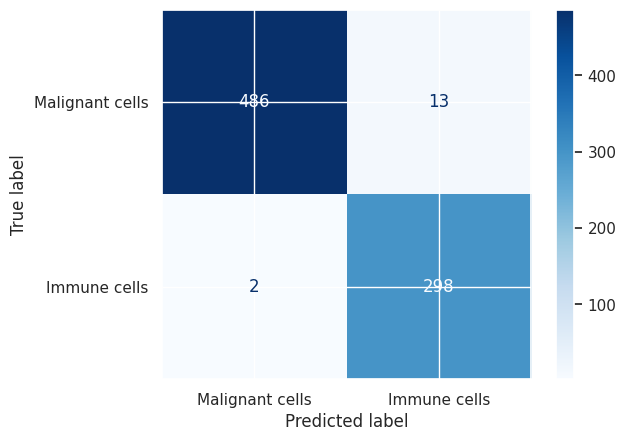

In [50]:
f, ax = plt.subplots() 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label2id.keys())
disp.plot(values_format='d', cmap=plt.cm.Blues,ax=ax)
#plt.xticks(rotation=60)
plt.savefig('cm.png', dpi=600, bbox_inches='tight')
plt.show()

<Axes: xlabel='umap 1', ylabel='umap 2'>

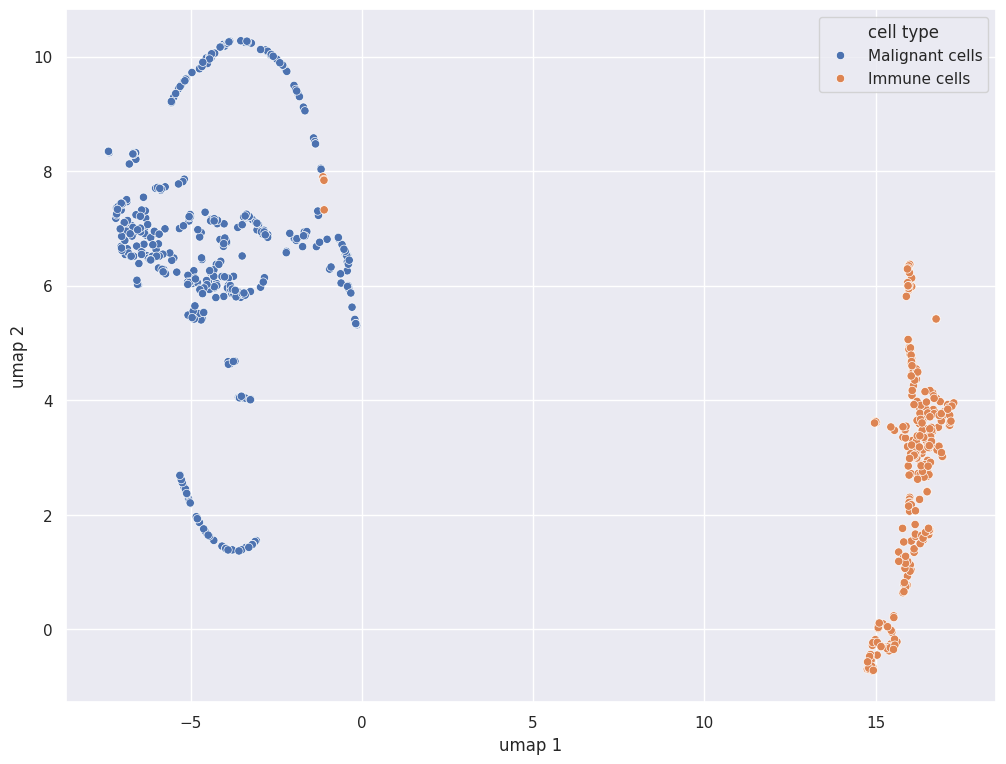

In [71]:
genemodel = BertModel.from_pretrained("./bestmodel",ignore_mismatched_sizes=True).to("cuda")
gene_emb = []
for i,(batch_data) in enumerate(test_dataset):
    tmp = collate_fn._prepare_batch([batch_data])
    input_ids, attention_mask,labels = tmp['input_ids'].to("cuda"),tmp['attention_mask'].to("cuda"),tmp['label'].to("cuda")
    gene_emb.append(genemodel(input_ids=input_ids,attention_mask=attention_mask).pooler_output.cpu()[0].detach().numpy())
gene_emb = np.array(gene_emb)

umap_model = UMAP(n_neighbors=15, n_components=2,min_dist=0.0, metric='cosine', random_state=42,low_memory=False) 
X_emb_umap = umap_model.fit_transform(gene_emb)

tmp = pd.DataFrame(X_emb_umap,columns=['umap 1','umap 2'])
tmp['cell type'] = y_pred
tmp['cell type'] = tmp['cell type'].map({0:'Malignant cells',1:'Immune cells'})
f, ax = plt.subplots(figsize=(12,9))  #画布大小
sns.scatterplot(data=tmp, x="umap 1", y="umap 2", hue="cell type")